In [179]:
from zentools.data_operations import slice_dataframe_by_date, add_macd, add_ewm_rsi, add_rsi
import pandas as pd
import numpy as np

In [180]:
# Load the CSV without the deprecated 'date_parser'
data = pd.read_csv("/home/bobo/Documents/Datasets/Binance_ETHUSDT_1h .csv", parse_dates=["Date"], index_col="Date")

# Convert the index to datetime manually (to ensure proper handling of any date format)
data.index = pd.to_datetime(data.index, format='ISO8601')

# Sort the DataFrame by index
data = data.sort_index()

In [181]:
add_macd(data, 12, 26, 9)
add_rsi(data)
data['Close'] = data['Close'].pct_change()
data['Volume ETH'] = data['Volume ETH'].pct_change()
data['EMA_12'] = data['EMA_12'].pct_change()
data['EMA_26'] = data['EMA_26'].pct_change()
data['tradecount'] = data['tradecount'].pct_change()
# clip
data['Close'] = data['Close'].clip(-1, 1)
data['Volume ETH'] = data['Volume ETH'].clip(-1, 1)
data['EMA_12'] = data['EMA_12'].clip(-1, 1)
data['EMA_26'] = data['EMA_26'].clip(-1, 1)
data['tradecount'] = data['tradecount'].clip(-1, 1)
# Replace +inf and -inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.fillna(0)
data.head()

,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount,EMA_12,EMA_26,MACD,Signal_Line,Histogram,RSI
Date,,,,,,,,,,,,,,
2017-08-17 04:00:00,ETHUSDT,301.13,302.57,298.0,0.000000,0.000000,37684.804181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-08-17 05:00:00,ETHUSDT,301.61,303.28,300.0,0.004940,1.000000,114043.282676,0.565891,0.000760,0.000366,0.118860,0.023772,0.095088,0.0
2017-08-17 06:00:00,ETHUSDT,302.40,304.44,301.9,-0.001386,-0.195423,92034.441294,-0.099010,0.000429,0.000236,0.177126,0.054443,0.122683,0.0
2017-08-17 07:00:00,ETHUSDT,302.68,307.96,302.6,0.017444,1.000000,229725.136967,0.087912,0.003052,0.001514,0.641953,0.171945,0.470008,0.0
2017-08-17 08:00:00,ETHUSDT,307.95,309.97,307.0,0.002143,-0.800263,46559.462371,-0.080808,0.002910,0.001562,1.051468,0.347850,0.703619,0.0


In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
# Assuming Date is already the index, only select the relevant features (excluding Date)
features = ['Open','High','Low','Close', 'Volume ETH','Volume USDT', 'tradecount','EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'Histogram','RSI']

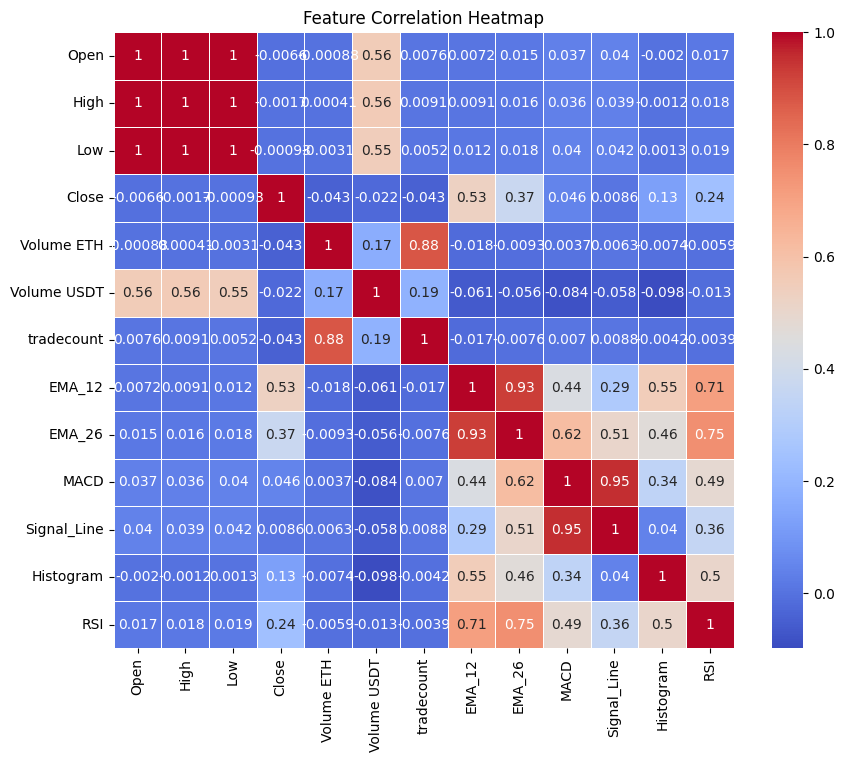

In [185]:
# Compute correlation matrix
correlation_matrix = data[features].corr()
# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
# Select features with correlation < 0.8
threshold = 0.8
high_corr_features = np.where(np.abs(correlation_matrix) > threshold)
high_corr_features = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) 
                      for x, y in zip(*high_corr_features) if x != y and x < y]

In [186]:
high_corr_features

[('Open', 'High'),
 ('Open', 'Low'),
 ('High', 'Low'),
 ('Volume ETH', 'tradecount'),
 ('EMA_12', 'EMA_26'),
 ('MACD', 'Signal_Line')]

In [187]:
# Remove highly correlated features
features_to_drop = [col for pair in high_corr_features for col in pair[1:]]
reduced_features = [f for f in data.columns if f not in features_to_drop]
data_reduced = data[reduced_features]
data_reduced = data_reduced.drop(columns=['Symbol'])
data_reduced.set_index('Close')
data_reduced.head()

,Open,Close,Volume ETH,Volume USDT,EMA_12,MACD,Histogram,RSI
Date,,,,,,,,
2017-08-17 04:00:00,301.13,0.000000,0.000000,37684.804181,0.000000,0.000000,0.000000,0.0
2017-08-17 05:00:00,301.61,0.004940,1.000000,114043.282676,0.000760,0.118860,0.095088,0.0
2017-08-17 06:00:00,302.40,-0.001386,-0.195423,92034.441294,0.000429,0.177126,0.122683,0.0
2017-08-17 07:00:00,302.68,0.017444,1.000000,229725.136967,0.003052,0.641953,0.470008,0.0
2017-08-17 08:00:00,307.95,0.002143,-0.800263,46559.462371,0.002910,1.051468,0.703619,0.0


In [188]:
# Percent change for key features
columns_to_transform = ['Open', 'Close', 'Volume ETH', 'Volume USDT', 'EMA_12', 'MACD']
# Iterate over the columns to transform
for col in columns_to_transform:
# Fill missing values using forward fill
    data[col] = data[col].fillna(method='ffill')
    
    # Compute percentage change with careful handling
    pct_change = data[col].pct_change()
    
    # Clip percentage changes to prevent extreme values
    # Use clip to limit values between -0.99 and 1
    # This prevents log transformation issues
    pct_change_clipped = pct_change.clip(-0.99, 1)
    
    # Safely apply log transformation
    # Use log(1+x) to handle zero and near-zero values
    # Adding 1 before log prevents issues with negative or zero values
    data[col] = np.log1p(np.abs(pct_change_clipped))
    
    # Store the percentage change 
    data[col] = pct_change_clipped

# Drop first row with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data_stationary = data.dropna()
data_reduced = data_stationary
data_reduced = data_reduced.iloc[12:]
# Drop the 'Symbol' column
data_reduced.drop(columns=['High', 'Low','Symbol', 'Signal_Line', 'EMA_26'], inplace=True)

/tmp/ipykernel_9452/1293735350.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method='ffill')
/tmp/ipykernel_9452/1293735350.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method='ffill')
/tmp/ipykernel_9452/1293735350.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method='ffill')
/tmp/ipykernel_9452/1293735350.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method='ffill')
/tmp/ipykernel_9452/1293735350.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Us

In [189]:
data_reduced

,Open,Close,Volume ETH,Volume USDT,tradecount,EMA_12,MACD,Histogram,RSI
Date,,,,,,,,,
2017-08-17 17:00:00,0.000845,-0.650008,-0.990000,-0.676759,-0.578199,0.128420,-0.012786,0.101697,0.000000
2017-08-17 18:00:00,0.001071,1.000000,-0.990000,0.063518,0.028090,0.429899,0.014755,0.101333,72.172883
2017-08-17 19:00:00,0.002497,-0.990000,-0.035198,0.053145,-0.049180,-0.990000,-0.348420,-0.397571,46.724891
2017-08-17 20:00:00,-0.024264,-0.990000,1.000000,0.254730,0.385057,-0.693108,-0.202908,-0.499680,54.109856
2017-08-17 21:00:00,0.010577,-0.177974,-0.189792,0.223649,0.058091,-0.990000,0.026194,-0.381056,48.871528
...,...,...,...,...,...,...,...,...,...
2023-10-19 19:00:00,-0.000186,-0.990000,-0.012876,-0.204644,-0.121583,1.000000,-0.922127,2.233627,74.061433
2023-10-19 20:00:00,0.004060,-0.990000,-0.990000,0.435152,0.195026,-0.309399,-0.990000,2.215425,73.333333
2023-10-19 21:00:00,-0.000950,1.000000,-0.990000,-0.401054,-0.207436,-0.612789,0.367732,1.909193,66.495287


In [190]:
# Example data
X, y = data_reduced.drop(columns=["Close"]), data_reduced["Close"]  # Replace with your features/target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [192]:
# Lasso and Ridge pipelines
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge()
}

In [193]:
# Hyperparameter grid for tuning
param_grids = {
    "Lasso": {
        "model__alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
        "model__max_iter": [1000, 2000, 5000]  # Increase iterations
    },
    "Ridge": {
        "model__alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
        "model__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
    }
}

In [113]:
# Results dictionary
results = {}

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)), # Addd polynomial features
        ("scaler", MinMaxScaler()),  # Standardize features
        ("model", model)               # Add model (Lasso or Ridge)
    ])
    
    # Perform GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring="neg_mean_squared_error",
        cv=5,  # 5-fold cross-validation
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # Store results
    best_model = grid.best_estimator_
    results[name] = {
        "Best Parameters": grid.best_params_,
        "Train MSE": -grid.best_score_,
        "Test MSE": mean_squared_error(y_test, best_model.predict(X_test))
    }

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [194]:
# Display results
for name, result in results.items():
    print(f"\n{name} Results:")
    for key, value in result.items():
        print(f"{key}: {value}")


Lasso Results:
Best Parameters: {'model__alpha': 10.0, 'model__max_iter': 1000}
Train MSE: 24673477.08063938
Test MSE: 6496431.273250072

Ridge Results:
Best Parameters: {'model__alpha': 100.0, 'model__solver': 'sparse_cg'}
Train MSE: 24674120.305876605
Test MSE: 6503412.730648667


In [195]:
model = Lasso(alpha=10.0, random_state=42)
# Create the pipeline
pipeline = Pipeline([
    #("poly", PolynomialFeatures(degree=3, include_bias=False)), # Addd polynomial features
    ('scaler', StandardScaler()),  # Scale features between 0 and 1
    ('model', model)             # Regression model
])

In [196]:
model.fit(X_train, y_train)

Lasso(alpha=10.0, random_state=42)

In [197]:
y_pred = model.predict(X_test)

Text(0.5, 1.0, 'Actual vs Predicted Returns')

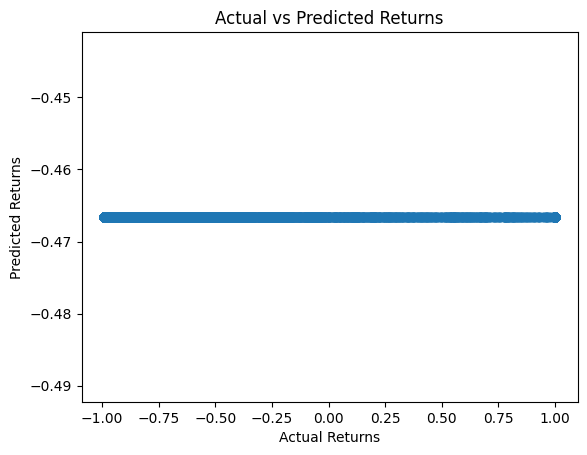

In [198]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Returns")

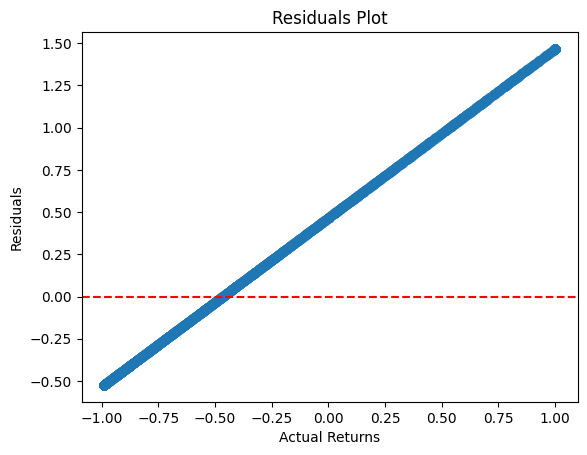

In [199]:
# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of residuals
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Returns")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()